In [20]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Add, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import Image
import IPython
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as patches
from PIL import Image

In [2]:
# Load the train and test set CSV files
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

EXPLORE THE DATA

In [3]:
# Explore the train dataset
print("Train Dataset:")
print(train_df.head())
print("\nNumber of samples in train dataset:", len(train_df))
print("===============================================================================")
# Explore the test dataset
print("\n\nTest Dataset:")
print(test_df.head())

print("\nNumber of samples in test dataset:", len(test_df))

Train Dataset:
   class                            image_path           name   xmax   xmin  \
0    3.0  4a48c42c9579ec0399e6c5a3e825e765.jpg        GARBAGE  797.0  701.0   
1    3.0  4a48c42c9579ec0399e6c5a3e825e765.jpg        GARBAGE  932.0  786.0   
2    3.0  4a48c42c9579ec0399e6c5a3e825e765.jpg        GARBAGE  736.0  657.0   
3    7.0  ea906a663da6321bcef78be4b7d1afff.jpg  BAD_BILLBOARD  986.0  786.0   
4    8.0  1c7d48005a12d1b19261b8e71df7cafe.jpg   SAND_ON_ROAD  667.0  549.0   

    ymax   ymin  
0  262.0  211.0  
1  329.0  238.0  
2  275.0  229.0  
3  136.0    0.0  
4  228.0  179.0  

Number of samples in train dataset: 19950


Test Dataset:
                             image_path
0  953ab1447c46ecfef67ab14629cd70c7.jpg
1  e4ddbaa7970fca225a51288ce5f7d3f9.jpg
2  5b8120d69607a077b7583334be3ba18b.jpg
3  138b1dc82005b4c33e4886260649d313.jpg
4  0f91ec1533b845b13089f8cf4e0a36f7.jpg

Number of samples in test dataset: 2092


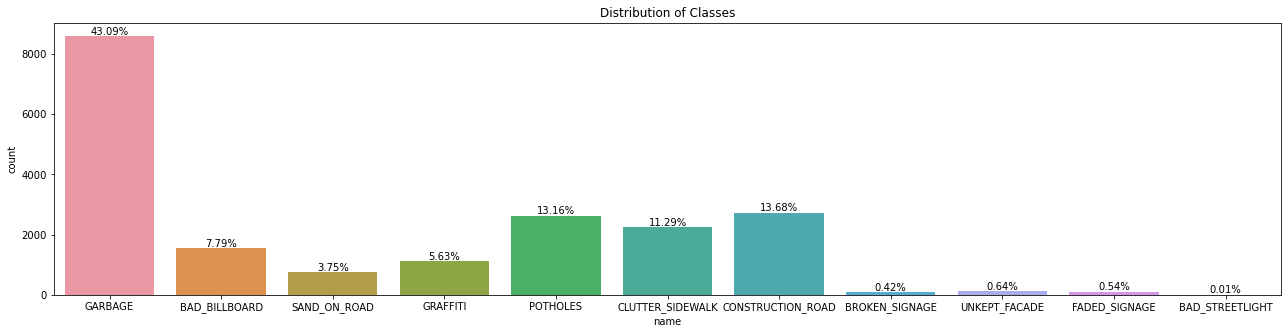

In [13]:
# visualize the distribution of each class
plt.figure(figsize=(22, 5))
sns.countplot(x='name', data=train_df)
plt.title('Distribution of Classes')
for i in plt.gca().patches:
    height = i.get_height()
    plt.gca().text(i.get_x()+i.get_width()/2., height + 50, '{:1.2f}%'.format(100*height/len(train_df)), ha="center")
plt.show()

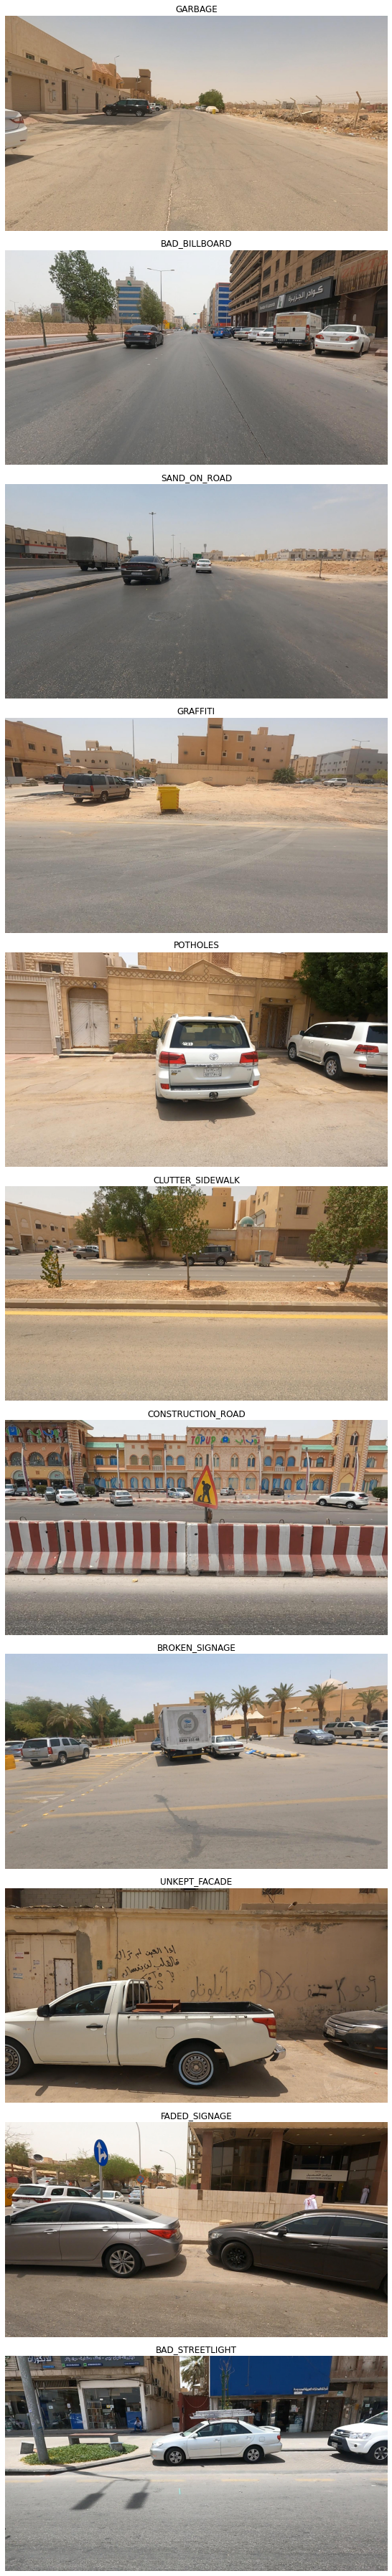

In [21]:
# Get unique classes in the train dataset
unique_classes = train_df['class'].unique()

# Set the number of columns for image display
num_columns = 1

# Calculate the number of rows based on the number of unique classes and columns
num_rows = (len(unique_classes) + num_columns - 1) // num_columns

# Explore one sample image for each class
image_path = "images/images/"
fig, axs = plt.subplots(num_rows, num_columns, figsize=(50, 50))
for i, class_label in enumerate(unique_classes):
    sample_image = train_df[train_df['class'] == class_label].iloc[0]
    img_path = os.path.join(image_path, sample_image['image_path'])
    img = plt.imread(img_path)
    ax = axs[i] if num_rows > 1 else axs
    ax.imshow(img)
    ax.set_title(sample_image['name'])
    ax.axis('off')
plt.tight_layout()
plt.show()

MODELLING

In [22]:
# Prepare the training data
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image_path = "images/images/"+row['image_path']
    label = row['class']
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))
    image = image.astype('float32') / 255.0
    
    train_images.append(image)
    train_labels.append(label)

In [23]:
# Convert the training data to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [24]:
# Perform label encoding on the training labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
train_labels = to_categorical(train_labels)

# 1st Tuning: Kerne size (3, 3)

In [8]:
# Split the training data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [9]:
# Define the model architecture
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(train_labels.shape[1], activation='softmax'))

2023-06-01 21:37:52.823095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Calculate the total number of parameters in the model
total_params = model.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [83]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
499/499 [==============================] - 71s 140ms/step - loss: 0.5893 - accuracy: 0.7860 - val_loss: 0.9964 - val_accuracy: 0.6822
Epoch 2/10
499/499 [==============================] - 63s 126ms/step - loss: 0.5547 - accuracy: 0.7947 - val_loss: 0.9167 - val_accuracy: 0.6977
Epoch 3/10
499/499 [==============================] - 60s 121ms/step - loss: 0.5249 - accuracy: 0.8058 - val_loss: 0.8626 - val_accuracy: 0.7216
Epoch 4/10
499/499 [==============================] - 68s 136ms/step - loss: 0.4928 - accuracy: 0.8147 - val_loss: 0.9002 - val_accuracy: 0.7168
Epoch 5/10
499/499 [==============================] - 66s 132ms/step - loss: 0.4771 - accuracy: 0.8179 - val_loss: 0.9282 - val_accuracy: 0.7123
Epoch 6/10
499/499 [==============================] - 58s 116ms/step - loss: 0.4625 - accuracy: 0.8228 - val_loss: 0.9136 - val_accuracy: 0.7055
Epoch 7/10
499/499 [==============================] - 58s 117ms/step - loss: 0.4368 - accuracy: 0.8320 - val_loss: 0.8620 - val_ac

# 2nd Tuning: Kernel size to  (5, 5)

The accuracy we got on the first tuning is quiet decent, but lets try another one

In [24]:
# Split the training data into train and validation sets
train_images2, val_images2, train_labels2, val_labels2 = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [28]:
# Define the model architecture
model2 = Sequential()

# Block 1
model2.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model2.add(Conv2D(64, (5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model2.add(Conv2D(128, (5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model2.add(Flatten())

# Fully connected layers
model2.add(Dense(128, activation='relu'))
model2.add(Dense(train_labels2.shape[1], activation='softmax'))

In [84]:
# Calculate the total number of parameters in the model
total_params = model2.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [85]:
# Compile the model
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(train_images2, train_labels2, epochs=10, validation_data=(val_images2, val_labels2))

Epoch 1/10
399/399 [==============================] - 76s 190ms/step - loss: 0.4744 - accuracy: 0.8236 - val_loss: 1.0782 - val_accuracy: 0.6977
Epoch 2/10
399/399 [==============================] - 73s 183ms/step - loss: 0.4487 - accuracy: 0.8258 - val_loss: 1.0396 - val_accuracy: 0.7112
Epoch 3/10
399/399 [==============================] - 70s 176ms/step - loss: 0.4403 - accuracy: 0.8290 - val_loss: 1.1058 - val_accuracy: 0.6977
Epoch 4/10
399/399 [==============================] - 75s 188ms/step - loss: 0.4290 - accuracy: 0.8321 - val_loss: 1.1022 - val_accuracy: 0.7068
Epoch 5/10
399/399 [==============================] - 77s 193ms/step - loss: 0.4077 - accuracy: 0.8428 - val_loss: 1.0983 - val_accuracy: 0.7052
Epoch 6/10
399/399 [==============================] - 73s 183ms/step - loss: 0.4056 - accuracy: 0.8428 - val_loss: 1.0891 - val_accuracy: 0.7124
Epoch 7/10
399/399 [==============================] - 71s 179ms/step - loss: 0.3972 - accuracy: 0.8430 - val_loss: 1.1406 - val_ac

the first tuninng got the better accuracy value, but we want to try another tuning

# 3nd Tuning: Kernel size to ( 7, 7 )

In [31]:
# Split the training data into train and validation sets
train_images3, val_images3, train_labels3, val_labels3 = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [44]:
# Define the model architecture
model3 = Sequential()

# Block 1
model3.add(Conv2D(32, (7, 7), activation='relu', input_shape=(128, 128, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model3.add(Conv2D(64, (7, 7), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model3.add(Conv2D(128, (7, 7), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model3.add(Flatten())

# Fully connected layers
model3.add(Dense(128, activation='relu'))
model3.add(Dense(train_labels3.shape[1], activation='softmax'))

In [86]:
# Calculate the total number of parameters in the model
total_params = model3.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [87]:
# Resize train_images3
resized_train_images3 = []
for image in train_images3:
    resized_image = cv2.resize(image, (128, 128))
    resized_train_images3.append(resized_image)
train_images3 = np.array(resized_train_images3)

# Resize val_images3
resized_val_images3 = []
for image in val_images3:
    resized_image = cv2.resize(image, (128, 128))
    resized_val_images3.append(resized_image)
val_images3 = np.array(resized_val_images3)


In [88]:
# Compile the model
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model3.fit(train_images3, train_labels3, epochs=10, validation_data=(val_images3, val_labels3))

Epoch 1/10
399/399 [==============================] - 543s 1s/step - loss: 0.6690 - accuracy: 0.7558 - val_loss: 1.0798 - val_accuracy: 0.6657
Epoch 2/10
399/399 [==============================] - 495s 1s/step - loss: 0.5984 - accuracy: 0.7845 - val_loss: 1.0098 - val_accuracy: 0.6877
Epoch 3/10
399/399 [==============================] - 548s 1s/step - loss: 0.5527 - accuracy: 0.7953 - val_loss: 1.0367 - val_accuracy: 0.6942
Epoch 4/10
399/399 [==============================] - 537s 1s/step - loss: 0.5264 - accuracy: 0.8069 - val_loss: 1.0606 - val_accuracy: 0.6880
Epoch 5/10
399/399 [==============================] - 485s 1s/step - loss: 0.5018 - accuracy: 0.8156 - val_loss: 1.0690 - val_accuracy: 0.7065
Epoch 6/10
399/399 [==============================] - 474s 1s/step - loss: 0.4600 - accuracy: 0.8247 - val_loss: 1.1271 - val_accuracy: 0.7033
Epoch 7/10
399/399 [==============================] - 486s 1s/step - loss: 0.4401 - accuracy: 0.8372 - val_loss: 1.0942 - val_accuracy: 0.6964

the first tuning seems better, lets use the same kernel size, and now we try to tune the learning rate

# 4th tuning: LR = 0.1

Since the first tuning got the highest Accuracy, now we try to tune the Learning rate.

In [101]:
# Split the training data into train and validation sets
train_images4, val_images4, train_labels4, val_labels4 = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [102]:
# Define the model architecture
model4 = Sequential()

# Block 1
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model4.add(Flatten())

# Fully connected layers
model4.add(Dense(128, activation='relu'))
model4.add(Dense(train_labels4.shape[1], activation='softmax'))

In [103]:
# Calculate the total number of parameters in the model
total_params = model4.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [104]:
# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model4.fit(train_images4, train_labels4, epochs=10, validation_data=(val_images4, val_labels4))

Epoch 1/10
399/399 [==============================] - 63s 155ms/step - loss: 2777.2725 - accuracy: 0.4204 - val_loss: 1.7633 - val_accuracy: 0.4229
Epoch 2/10
399/399 [==============================] - 46s 116ms/step - loss: 1.7175 - accuracy: 0.4311 - val_loss: 1.7597 - val_accuracy: 0.4229
Epoch 3/10
399/399 [==============================] - 46s 116ms/step - loss: 1.7190 - accuracy: 0.4311 - val_loss: 1.7593 - val_accuracy: 0.4229
Epoch 4/10
399/399 [==============================] - 47s 117ms/step - loss: 1.7188 - accuracy: 0.4311 - val_loss: 1.7647 - val_accuracy: 0.4229
Epoch 5/10
399/399 [==============================] - 47s 118ms/step - loss: 1.7211 - accuracy: 0.4311 - val_loss: 1.7604 - val_accuracy: 0.4229
Epoch 6/10
399/399 [==============================] - 46s 116ms/step - loss: 1.7211 - accuracy: 0.4311 - val_loss: 1.7686 - val_accuracy: 0.4229
Epoch 7/10
399/399 [==============================] - 48s 119ms/step - loss: 1.7202 - accuracy: 0.4311 - val_loss: 1.7634 - val

the accuray is stuck on 42% which is bad, lets try another LR value

# 5th tuning: LR = 0.001

In [106]:
# Split the training data into train and validation sets
train_images55, val_images5, train_labels5, val_labels5 = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [107]:
# Define the model architecture
model5 = Sequential()

# Block 1
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model5.add(Flatten())

# Fully connected layers
model5.add(Dense(128, activation='relu'))
model5.add(Dense(train_labels5.shape[1], activation='softmax'))

In [108]:
# Calculate the total number of parameters in the model
total_params = model5.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [109]:
# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model5.fit(train_images5, train_labels5, epochs=10, validation_data=(val_images5, val_labels5))

Epoch 1/10
399/399 [==============================] - 70s 175ms/step - loss: 1.6436 - accuracy: 0.4477 - val_loss: 1.5159 - val_accuracy: 0.4818
Epoch 2/10
399/399 [==============================] - 73s 182ms/step - loss: 1.3831 - accuracy: 0.5186 - val_loss: 1.4206 - val_accuracy: 0.5056
Epoch 3/10
399/399 [==============================] - 78s 197ms/step - loss: 1.2569 - accuracy: 0.5544 - val_loss: 1.2631 - val_accuracy: 0.5533
Epoch 4/10
399/399 [==============================] - 71s 178ms/step - loss: 1.1658 - accuracy: 0.5846 - val_loss: 1.1726 - val_accuracy: 0.5946
Epoch 5/10
399/399 [==============================] - 65s 164ms/step - loss: 1.0753 - accuracy: 0.6194 - val_loss: 1.1540 - val_accuracy: 0.6006
Epoch 6/10
399/399 [==============================] - 67s 169ms/step - loss: 1.0016 - accuracy: 0.6440 - val_loss: 1.1304 - val_accuracy: 0.5949
Epoch 7/10
399/399 [==============================] - 58s 145ms/step - loss: 0.9380 - accuracy: 0.6637 - val_loss: 1.0877 - val_ac

# 6th tuning: Activation (sigmoid)

we want to try to use sigmoid as output layer activation for the first tuningn and the second one, now lets try to the second tuning first.

In [76]:
# Split the training data into train and validation sets
train_images6, val_images6, train_labels6, val_labels6 = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [77]:
# Define the model architecture
model6 = Sequential()

# Block 1
model6.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model6.add(Conv2D(64, (5, 5), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model6.add(Conv2D(128, (5, 5), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model6.add(Conv2D(128, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model6.add(Flatten())

# Fully connected layers
model6.add(Dense(128, activation='relu'))
model6.add(Dense(train_labels6.shape[1], activation='sigmoid'))

In [93]:
# Calculate the total number of parameters in the model
total_params = model6.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [94]:
# Compile the model
model6.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model6.fit(train_images6, train_labels6, epochs=10, validation_data=(val_images6, val_labels6))

Epoch 1/10
399/399 [==============================] - 69s 171ms/step - loss: 0.6867 - accuracy: 0.7576 - val_loss: 1.0279 - val_accuracy: 0.6670
Epoch 2/10
399/399 [==============================] - 68s 171ms/step - loss: 0.6330 - accuracy: 0.7733 - val_loss: 1.0638 - val_accuracy: 0.6767
Epoch 3/10
399/399 [==============================] - 69s 173ms/step - loss: 0.6041 - accuracy: 0.7827 - val_loss: 1.0205 - val_accuracy: 0.6911
Epoch 4/10
399/399 [==============================] - 67s 169ms/step - loss: 0.5624 - accuracy: 0.7953 - val_loss: 1.0414 - val_accuracy: 0.6820
Epoch 5/10
399/399 [==============================] - 68s 169ms/step - loss: 0.5363 - accuracy: 0.8059 - val_loss: 1.0516 - val_accuracy: 0.7039
Epoch 6/10
399/399 [==============================] - 67s 169ms/step - loss: 0.5070 - accuracy: 0.8077 - val_loss: 1.0379 - val_accuracy: 0.7030
Epoch 7/10
399/399 [==============================] - 68s 170ms/step - loss: 0.4825 - accuracy: 0.8206 - val_loss: 1.0629 - val_ac

# 7th tuning: last layer filter to 256

using our last tuning, we want to try to change the filterr for block 4 convo2D to 256

In [79]:
# Split the training data into train and validation sets
train_images7, val_images7, train_labels7, val_labels7 = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [80]:
# Define the model architecture
model7 = Sequential()

# Block 1
model7.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model7.add(Conv2D(64, (5, 5), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model7.add(Conv2D(128, (5, 5), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model7.add(Conv2D(256, (3, 3), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model7.add(Flatten())

# Fully connected layers
model7.add(Dense(128, activation='relu'))
model7.add(Dense(train_labels7.shape[1], activation='sigmoid'))

In [95]:
# Calculate the total number of parameters in the model
total_params = model7.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [96]:
# Compile the model
model7.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model7.fit(train_images7, train_labels7, epochs=10, validation_data=(val_images7, val_labels7))

Epoch 1/10
399/399 [==============================] - 77s 192ms/step - loss: 0.6493 - accuracy: 0.7618 - val_loss: 1.0149 - val_accuracy: 0.6745
Epoch 2/10
399/399 [==============================] - 75s 187ms/step - loss: 0.5929 - accuracy: 0.7837 - val_loss: 0.9537 - val_accuracy: 0.7058
Epoch 3/10
399/399 [==============================] - 72s 181ms/step - loss: 0.5534 - accuracy: 0.7962 - val_loss: 0.9806 - val_accuracy: 0.7068
Epoch 4/10
399/399 [==============================] - 72s 181ms/step - loss: 0.5205 - accuracy: 0.8065 - val_loss: 0.9600 - val_accuracy: 0.7055
Epoch 5/10
399/399 [==============================] - 73s 182ms/step - loss: 0.4915 - accuracy: 0.8156 - val_loss: 1.0659 - val_accuracy: 0.6902
Epoch 6/10
399/399 [==============================] - 74s 186ms/step - loss: 0.4756 - accuracy: 0.8202 - val_loss: 0.9965 - val_accuracy: 0.7184
Epoch 7/10
399/399 [==============================] - 72s 180ms/step - loss: 0.4486 - accuracy: 0.8271 - val_loss: 0.9931 - val_ac

# 8th tuning: last layer filter to 256 - output layer (sigmoid)

now we are trying to tune the first tuning, we change the block 4 filter to 256 and output layer activation as sigmoid

In [97]:
# Split the training data into train and validation sets
train_images8, val_images8, train_labels8, val_labels8 = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [98]:
# Define the model architecture
model8 = Sequential()

# Block 1
model8.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model8.add(Conv2D(64, (3, 3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model8.add(Conv2D(128, (3, 3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model8.add(Conv2D(256, (3, 3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and concatenate
model8.add(Flatten())

# Fully connected layers
model8.add(Dense(128, activation='relu'))
model8.add(Dense(train_labels8.shape[1], activation='sigmoid'))

In [99]:
# Calculate the total number of parameters in the model
total_params = model8.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [110]:
# Compile the model
model8.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model8.fit(train_images8, train_labels8, epochs=10, validation_data=(val_images8, val_labels8))

Epoch 1/10
399/399 [==============================] - 76s 189ms/step - loss: 0.3793 - accuracy: 0.8495 - val_loss: 1.0051 - val_accuracy: 0.7165
Epoch 2/10
399/399 [==============================] - 61s 153ms/step - loss: 0.3572 - accuracy: 0.8535 - val_loss: 1.0806 - val_accuracy: 0.7209
Epoch 3/10
399/399 [==============================] - 61s 152ms/step - loss: 0.3481 - accuracy: 0.8584 - val_loss: 1.0356 - val_accuracy: 0.7249
Epoch 4/10
399/399 [==============================] - 61s 153ms/step - loss: 0.3456 - accuracy: 0.8541 - val_loss: 1.0343 - val_accuracy: 0.7224
Epoch 5/10
399/399 [==============================] - 61s 153ms/step - loss: 0.3321 - accuracy: 0.8603 - val_loss: 1.1298 - val_accuracy: 0.7096
Epoch 6/10
399/399 [==============================] - 62s 155ms/step - loss: 0.3266 - accuracy: 0.8639 - val_loss: 1.1138 - val_accuracy: 0.7162
Epoch 7/10
399/399 [==============================] - 61s 152ms/step - loss: 0.3301 - accuracy: 0.8618 - val_loss: 1.0927 - val_ac

# Try using ResNet Architecture


In [25]:
# Split the training data into train and validation sets
train_imagesRN, val_imagesRN, train_labelsRN, val_labelsRN = train_test_split(train_images, train_labels, test_size=0.2,
                                                                      random_state=42)

In [26]:
# Define the model architecture
modelRN = Sequential()

# Block 1
modelRN.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
modelRN.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
modelRN.add(Conv2D(64, (3, 3), activation='relu'))
modelRN.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
modelRN.add(Conv2D(128, (3, 3), activation='relu'))
modelRN.add(MaxPooling2D(pool_size=(2, 2)))

# Residual Block 4
block_4 = Sequential()
block_4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
block_4.add(BatchNormalization())
block_4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
block_4.add(BatchNormalization())

# Add the residual connection
block_3_output = modelRN.output
block_3_output = Conv2D(256, (1, 1), activation='relu')(block_3_output)
block_4_output = block_4(block_3_output)
residual_output = Add()([block_3_output, block_4_output])

# Flatten and fully connected layers
modelRN.add(Flatten())
modelRN.add(Dense(128, activation='relu'))
modelRN.add(Dense(train_labelsRN.shape[1], activation='sigmoid'))


2023-06-18 10:44:30.573439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Calculate the total number of parameters in the model
total_params = modelRN.count_params()

# Check if the total number of parameters is less than 10 million
if total_params > 10000000:
    raise ValueError("Total number of parameters exceeds 10 million. Please adjust the model architecture.")

In [29]:
# Compile the model
modelRN.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
modelRN.fit(train_imagesRN, train_labelsRN, epochs=10, validation_data=(val_imagesRN, val_labelsRN))

Epoch 1/10
499/499 [==============================] - 54s 106ms/step - loss: 0.4808 - accuracy: 0.8192 - val_loss: 0.8711 - val_accuracy: 0.7303
Epoch 2/10
499/499 [==============================] - 55s 109ms/step - loss: 0.4424 - accuracy: 0.8277 - val_loss: 0.9095 - val_accuracy: 0.7238
Epoch 3/10
499/499 [==============================] - 53s 106ms/step - loss: 0.4285 - accuracy: 0.8340 - val_loss: 0.8874 - val_accuracy: 0.7251
Epoch 4/10
499/499 [==============================] - 53s 105ms/step - loss: 0.4090 - accuracy: 0.8404 - val_loss: 0.9047 - val_accuracy: 0.7293
Epoch 5/10
499/499 [==============================] - 53s 105ms/step - loss: 0.3940 - accuracy: 0.8406 - val_loss: 0.8939 - val_accuracy: 0.7271
Epoch 6/10
499/499 [==============================] - 55s 111ms/step - loss: 0.3818 - accuracy: 0.8434 - val_loss: 0.8990 - val_accuracy: 0.7338
Epoch 7/10
499/499 [==============================] - 59s 117ms/step - loss: 0.3711 - accuracy: 0.8466 - val_loss: 0.8814 - val_ac

# Conclusion
Using ResNet Architecture, we got accuracy of 74.3%

### Test data

In [30]:
# Prepare the test data
test_images = []

for index, row in test_df.iterrows():
    image_path = "images/images/"+row['image_path']
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64))
    image = image.astype('float32') / 255.0
    
    test_images.append(image) 

In [31]:
# Convert the test data to numpy arrays
test_images = np.array(test_images)

# Make predictions on the test data
predictions = modelRN.predict(test_images)

66/66 [==============================] - 2s 29ms/step


In [130]:
# Retrievinng 'class' columns inside train_df to get list of Classes
Class = train_df['class']
ClassList = np.unique(Class)

# Print
print(ClassList)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [32]:
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Map class labels to their respective names
class_names = ["0.",  "1.",  "2.",  "3.",  "4.", "5.", "6.",  "7.",  "8.",  "9.", "10."]  # List of class names
predicted_labels = [class_names[i] for i in predicted_classes]

# Create a DataFrame to store the results
results_df = test_df.copy()
results_df["predicted_class"] = predicted_classes
results_df["Actual_class"] = predicted_labels

# Save the results to a CSV file
results_df.to_csv("BestPredictions.csv", index=False)

In [33]:
# See The predicion and Actual Class on validation dataset
valid_predictions = modelRN.predict(val_imagesRN)

125/125 [==============================] - 4s 33ms/step


In [34]:
# Convert predictions to class labels
valid_predicted_classes = np.argmax(valid_predictions, axis=1)
valid_actual_classes = np.argmax(val_labelsRN, axis=1)

# Map class labels to their respective names
valid_class_names = ["0.",  "1.",  "2.",  "3.",  "4.", "5.", "6.",  "7.",  "8.",  "9.", "10."]  # List of class names
valid_predicted_labels = [valid_class_names[i] for i in valid_predicted_classes]
valid_actual_labels = [valid_class_names[i] for i in valid_actual_classes]

# Create a DataFrame to store the results
valid_results_df = pd.DataFrame({'Actual Class': valid_actual_labels, 'Predicted Class': valid_predicted_labels})

# Print the results
print(valid_results_df)


     Actual Class Predicted Class
0              4.              4.
1              3.              3.
2              4.              4.
3              3.              3.
4              4.              4.
...           ...             ...
3985           8.              8.
3986           2.              3.
3987           9.              9.
3988           3.              3.
3989           2.              2.

[3990 rows x 2 columns]
